## Libraries

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path

# Third-party imports
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import numpy as np
import buteo as beo
from tqdm import tqdm
import matplotlib.pyplot as plt
import import_ipynb
from glob import glob

# Local imports
from utilities import render_s2_as_rgb, custom_subplots
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
TEST_INDICES = [15, 6, 22, 57, 45, 22, 31]

## Model Definition

The model will take as input an image containing the 9 spectral bands from Sentinel-2 (normalised and split up into patches of 32x32). The output will be the building density of the pixel ranging between 0-100, which means we are doing a regression task as we are trying to predict specific values.

In this architecture, there is an encoder block where the number of channels is increased to 128. Because of the padding, the resolution of the output channels is unchanged. In the decoder block, there are extra convolutions that bring the number of channels back to a single one that contains the building density.

To help the model, we force the values to lie between the range of 0-100, since any other values will never be correct.

In [3]:
class SimpleConvNet(nn.Module):
  """
  A simple convolutional neural network that encodes input images
  and decodes them back to a single-channel output image.
  """
  def __init__(self, input_channels: int, output_min: float, output_max: float) -> None:
    super(SimpleConvNet, self).__init__()
    self.output_min = output_min
    self.output_max = output_max

    # An encoder without a bottleneck
    self.encoder = nn.Sequential(
      nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64),
      nn.Dropout(0.1),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(128),
      nn.Dropout(0.1),
    )

    # Simple decoder
    self.decoder = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64),
      nn.Dropout(0.1),
      nn.Conv2d(64, 1, kernel_size=3, padding=1),
    )
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Forward pass through the network.
    """
    x = self.encoder(x)
    x = self.decoder(x)

    # Clamp the output values to be within [output_min, output_max]
    x = torch.clamp(x, self.output_min, self.output_max)
    return x

## Initalise the Model

In [4]:
input_channels = 9 # Sentinel 2 initially.

# Initialise the model
model = SimpleConvNet(input_channels, 0.0, 100.0) # Since we know the labels will always be [0.0, 100.0]

# Constants for the model
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.001

In [5]:
class NumpyDataset(Dataset):
  """
  A simple dataset class that loads numpy arrays ensuring channel-first format for PyTorch.
  """
  def __init__(self, x_train: np.ndarray, y_train: np.ndarray, data_is_channel_last: bool = False) -> None:
    if data_is_channel_last:
      x_train = beo.channel_last_to_first(x_train)
      y_train = beo.channel_last_to_first(y_train)
    
    self.x_train = torch.from_numpy(x_train).float()
    self.y_train = torch.from_numpy(y_train).float()
  
  def __len__(self) -> int:
    """
    Returns the number of samples in the dataset.
    """
    return len(self.x_train)
  
  def __getitem__(self, idx: int) -> tuple:
    """
    Returns a single sample from the dataset.
    """
    x = self.x_train[idx]
    y = self.y_train[idx]
    
    return x, y

## Load the Data

In [6]:
DATA_FOLDER = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

x_train = np.load(os.path.join(DATA_FOLDER, 'train.npz'))['x_s2'] # Initially we only load the S2 data
y_train = np.load(os.path.join(DATA_FOLDER, 'train.npz'))['y']
x_val = np.load(os.path.join(DATA_FOLDER, 'val.npz'))['x_s2']
y_val = np.load(os.path.join(DATA_FOLDER, 'val.npz'))['y']

# Prepare the data for pytorch
def callback(x: np.ndarray, y: np.ndarray) -> tuple:
    """
    Callback function to prepare the data for PyTorch.
    """
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    return x, y

### Create Dataset and DataLoader

In [7]:
# Training Data Loader
dataset = NumpyDataset(x_train, y_train, data_is_channel_last=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0)

# Validation Data Loader
val_dataset = NumpyDataset(x_val, y_val, data_is_channel_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)

## Train the Model

In [ ]:
def train_model(model: nn.Module, dataloader: DataLoader, val_loader: DataLoader) -> None:
  # Define the loss function and optimizer
  criterion = nn.MSELoss()
  optimiser = Adam(model.parameters(), lr=LEARNING_RATE)

  # Move the model to the device
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Training loop
  for epoch in range(EPOCHS):
    running_loss = 0.0

    # Initialise the progress bar for training
    train_pbar = tqdm(dataloader, total=len(dataloader), ncols=120)

    for i, (inputs, targets) in enumerate(train_pbar):
      # Move inputs and targets to the device
      inputs, targets = inputs.to(device), targets.to(device)

      # Zero the gradients
      optimiser.zero_grad()

      # Forward pass
      outputs = model(inputs)

      # Compute the loss
      loss = criterion(outputs, targets)

      # Backward pass and optimization
      loss.backward()
      optimiser.step()

      # Print the statistics
      current_loss = loss.item()
      running_loss += current_loss
      mean_loss = running_loss / (i + 1)

      # Update the progress bar
      train_pbar.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]")
      print_dict = { 'loss': f'{mean_loss:4f}'}
      train_pbar.set_postfix(print_dict)

    # Validation step
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
      val_pbar = tqdm(val_loader, total=len(val_loader), ncols=120, desc='Validation')
      for inputs, targets in val_pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item()
      
      val_mean_loss = val_loss / len(val_loader)
      print(f"Epoch [{epoch + 1}/{EPOCHS}] - Validation Loss: {val_mean_loss:.4f}")

In [11]:
train_model(model, dataloader, val_loader)

Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:06<00:00, 34.27it/s]


Epoch [1/10] - Validation Loss: 441.1813


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:05<00:00, 40.07it/s]


Epoch [2/10] - Validation Loss: 433.6730


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:06<00:00, 33.64it/s]


Epoch [3/10] - Validation Loss: 415.5040


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:06<00:00, 32.77it/s]


Epoch [4/10] - Validation Loss: 407.5770


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:06<00:00, 30.78it/s]


Epoch [5/10] - Validation Loss: 395.2250


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:05<00:00, 34.41it/s]


Epoch [6/10] - Validation Loss: 407.3801


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:08<00:00, 23.79it/s]


Epoch [7/10] - Validation Loss: 403.5110


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:09<00:00, 21.65it/s]


Epoch [8/10] - Validation Loss: 385.8964


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:05<00:00, 37.62it/s]


Epoch [9/10] - Validation Loss: 400.7132


Validation: 100%|█████████████████████████████████████████████████████████████████████| 206/206 [00:09<00:00, 22.49it/s]

Epoch [10/10] - Validation Loss: 391.6819


## Save the Model

In [12]:
# Save the model 
model_folder = '../models'

# Ensure the output directory exists
Path(model_folder).mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), os.path.join(model_folder, 'model_01.pth'))
del dataset, dataloader

## Test the Model

In [14]:
# Load the Model
model.load_state_dict(torch.load(os.path.join('../models', 'model_01.pth')))
model.eval()

# Move the model to the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

C:\Users\dango\AppData\Local\Temp\ipykernel_2576\1157911625.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('../models', 'm

SimpleConvNet(
  (encoder): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [15]:
# Clear GUP memory
if torch.cuda.is_available():
  torch.cuda.empty_cache()

with torch.no_grad():
  X_test = beo.channel_last_to_first(np.load(os.path.join(DATA_FOLDER, 'test.npz'))['x_s2'])
  y_test = beo.channel_last_to_first(np.load(os.path.join(DATA_FOLDER, 'test.npz'))['y'])
  y_pred = model(torch.from_numpy(X_test).float().to(device)).cpu().detach().numpy()

print('Building Density Metrics:')
print('\tRMSE:', np.sqrt(np.mean((y_test - y_pred)  ** 2)))
print('\tMAE:', np.mean(np.abs(y_test - y_pred)))
print('\tMSE:', np.mean((y_test - y_pred) ** 2))

# Recast the problem to a classification problem
threshold = 1 # If 1m^2 of the pixel is covered by buildings, we say that buildings are present
y_test_classification = np.where(y_test > threshold, 1, 0)
y_pred_classification = np.where(y_pred > threshold, 1, 0)

print('\n\nClassification Metrics:')
print('\tAccuracy:', 1-np.mean(np.abs(y_test_classification - y_pred_classification)))


Building Density Metrics:
	RMSE: 16.722393
	MAE: 6.9801893
	MSE: 279.63846


Classification Metrics:
	Accuracy: 0.8120734554597702


## Dig Deeper into the Metrics

In [16]:
def baseline_model_metrics(y_test: np.ndarray, baseline_pred: np.ndarray, y_test_classification: np.ndarray, threshold: float) -> None:
    """
    Print the metrics for the baseline model.

    Args:
        y_test (np.ndarray): The true values for the test set.
        baseline_pred (np.ndarray): The predictions from the baseline model.
        y_test_classification (np.ndarray): The true values for the classification task.
        threshold (float): The threshold for classification.
    """
    print('Baseline Model Metrics:')
    print('\tRMSE:', np.sqrt(np.mean((y_test - baseline_pred) ** 2)))
    print('\tMAE:', np.mean(np.abs(y_test - baseline_pred)))
    print('\tMSE:', np.mean((y_test - baseline_pred) ** 2))
    
    print('\nClassification Metrics:')
    print('\tAccuracy:', 1-np.mean(np.abs(y_test_classification - np.where(baseline_pred > threshold, 1, 0))))

Metrics for baseline model that always predicts 0:
Baseline Model Metrics:
	RMSE: 22.989945324182788
	MAE: 7.567736198279666
	MSE: 528.537586008914

Classification Metrics:
	Accuracy: 0.8396571367636494


Metric for baseline model that always predicts the mean of the train labels (3.18m^2).
Baseline Model Metrics:
	RMSE: 22.14861553323759
	MAE: 9.737462003720653
	MSE: 490.5611700391734

Classification Metrics:
	Accuracy: 0.1603428632363506


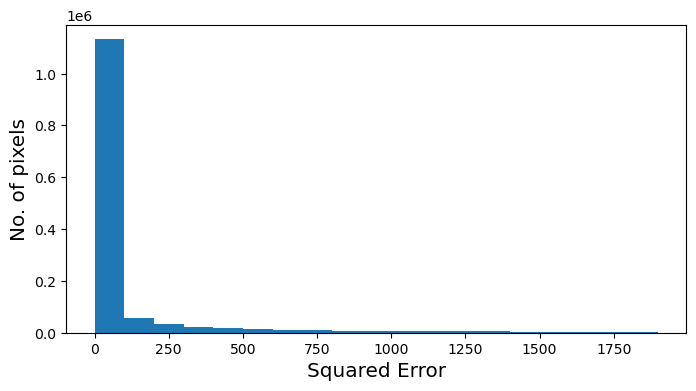

In [17]:
# Distribution of the SE loss
SE = (y_test - y_pred) ** 2

plt.figure(figsize=(8, 4))
plt.hist(SE.flatten(), bins=[100 * i for i in range(20)])
plt.ylabel('No. of pixels', size='x-large')
plt.xlabel('Squared Error', size='x-large')

# Some very simple baselines to compare the model against
baseline_pred_0 = np.zeros(y_pred.shape)
baseline_pred_mean = np.ones(y_pred.shape) * np.mean(y_train)

print('Metrics for baseline model that always predicts 0:')
baseline_model_metrics(y_test, baseline_pred_0, y_test_classification, threshold)

print(f"\n\nMetric for baseline model that always predicts the mean of the train labels ({np.mean(y_train):.2f}m^2).")
baseline_model_metrics(y_test, baseline_pred_mean, y_test_classification, threshold)

## Inspect Predictions on Test Set

In [18]:
def predict(arr: np.ndarray) -> np.ndarray:
  """
  Predict the output for a given input array using the trained model.
  
  Args:
      arr (np.ndarray): The input array to predict.
  
  Returns:
      np.ndarray: The predicted output.
  """
  swap = beo.channel_last_to_first(arr)
  as_torch = torch.from_numpy(swap).float().to(device)
  predicted = model(as_torch).cpu().numpy()
  swap_back = beo.channel_first_to_last(predicted)

  return swap_back

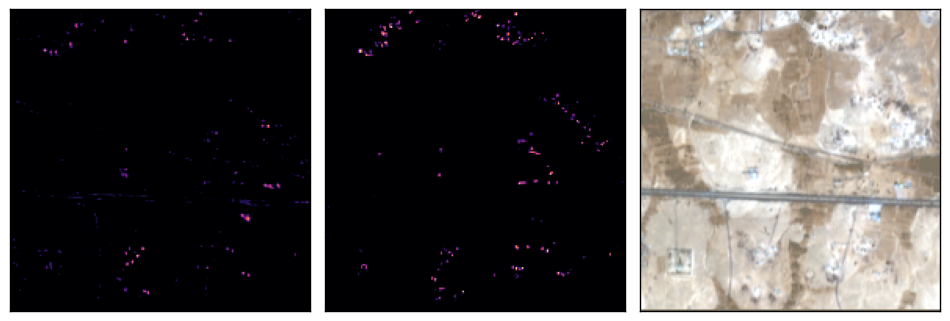

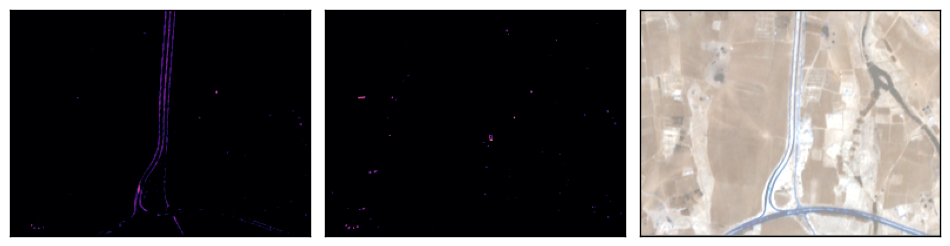

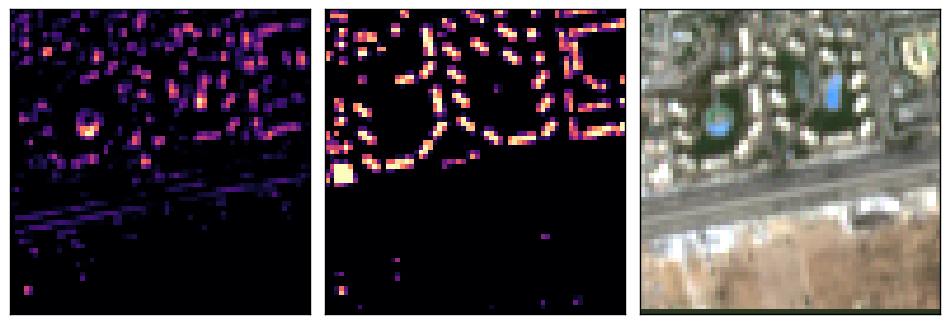

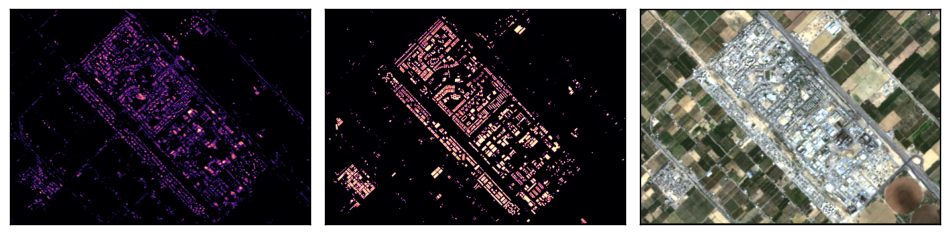

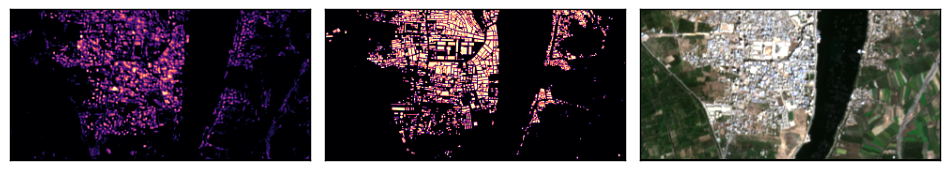

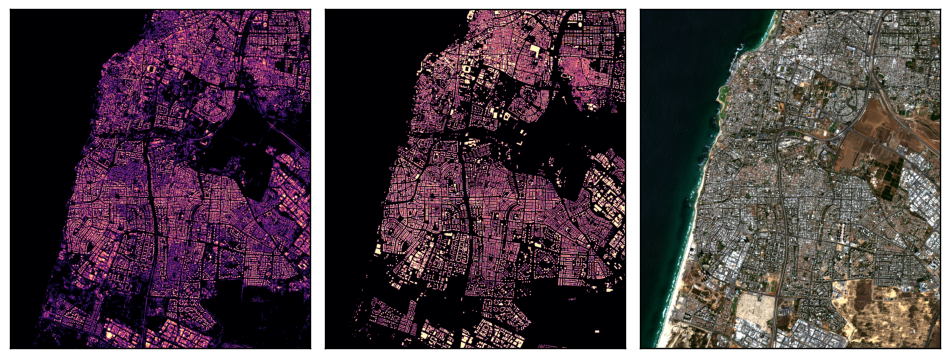

In [19]:
PATCH_SIZE = 32

# Read and order the tiles in a temporary folder
for image in zip(
  sorted(glob(os.path.join(DATA_FOLDER, 'CCAI_FLOODS_DATA', 'label_*.tif'))),
  sorted(glob(os.path.join(DATA_FOLDER, 'CCAI_FLOODS_DATA', 's1_*.tif'))),
  sorted(glob(os.path.join(DATA_FOLDER, 'CCAI_FLOODS_DATA', 's2_*.tif'))),
  sorted(glob(os.path.join(DATA_FOLDER, 'CCAI_FLOODS_DATA', 'dem_*.tif')))
):
  label_path, s1_path, s2_path, dem_path = image

  label_name = os.path.splitext(os.path.basename(label_path))[0]
  img_idx = int(label_name.split('_')[1])

  # Only predict test dataset
  if img_idx not in TEST_INDICES:
    continue

  # Load the s2 and label data
  arr_s2 = beo.raster_to_array(s2_path, filled=True, fill_value=0.0)
  arr_label = beo.raster_to_array(label_path, filled=True, fill_value=0.0)

  # Prepare the RGB render
  arr_s2_rgb = beo.raster_to_array(s2_path, filled=True, fill_value=0.0, bands=[3, 2, 1])
  rgb_render = render_s2_as_rgb(arr_s2_rgb)

  # Normalise the S2 data
  arr_s2, _statdict = beo.scaler_truncate(arr_s2, 0.0, 10000.0)
  arr_s2 = arr_s2.astype(np.float32, copy=False)

  with torch.no_grad():
    try:
      # Some of the testing data might be too small to patch. In that case, ignore them.
      # Predict the image and merge using the median of predictions.
      predicted = beo.predict_array(
        arr_s2,
        predict,
        tile_size=PATCH_SIZE,
        n_offsets=3,
        merge_method='median'
      )

      # Plot the prediction, the label, and the RGB
      fig, (ax1, ax2, ax3) = custom_subplots(nrows=1, ncols=3, size=(12, 8))
      ax1.imshow(predicted, vmin=0.0, vmax=100.0, cmap='magma')
      ax2.imshow(arr_label, vmin=0.0, vmax=100.0, cmap='magma')
      ax3.imshow(rgb_render)

      plt.show()
    except Exception as e:
      print(f'Error processing {label_name}: {e}')
      pass

 ## Inspect Predictions on all of Alexandria

Inspect how the model performs when predicting building density on the entire region of Alexandria. This includes regions for which we don't have any labels.

To avoid RAM overload, we split the scene in 9 chunks (using ``raster_to_array_chunks``) and predict them separately.

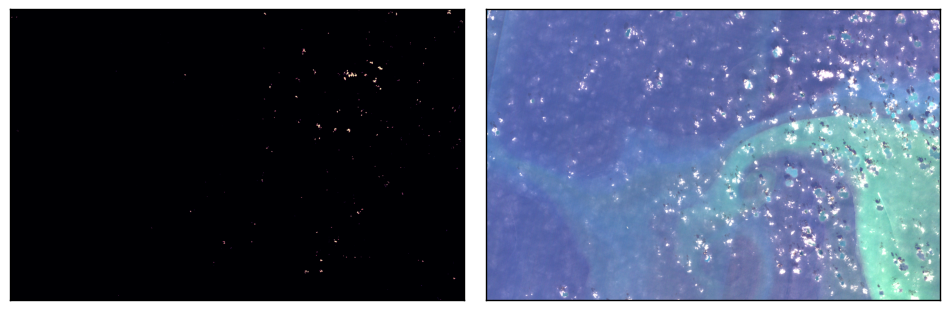

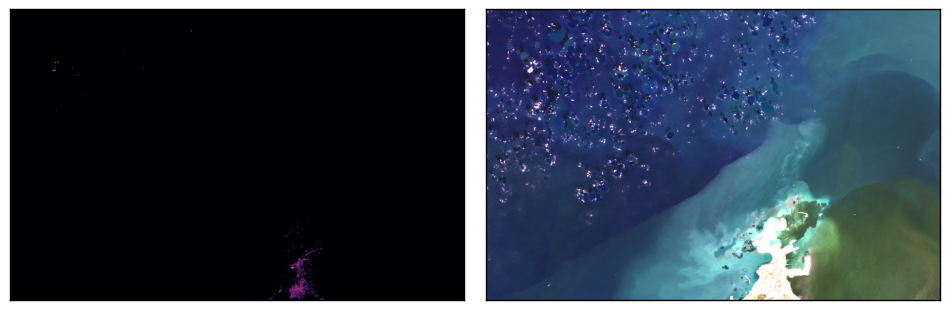

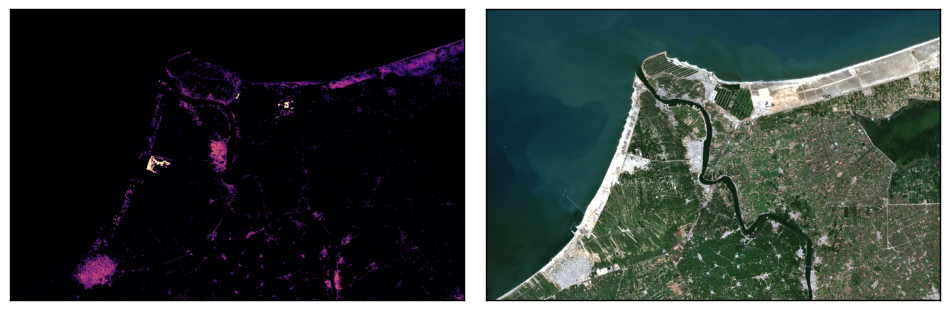

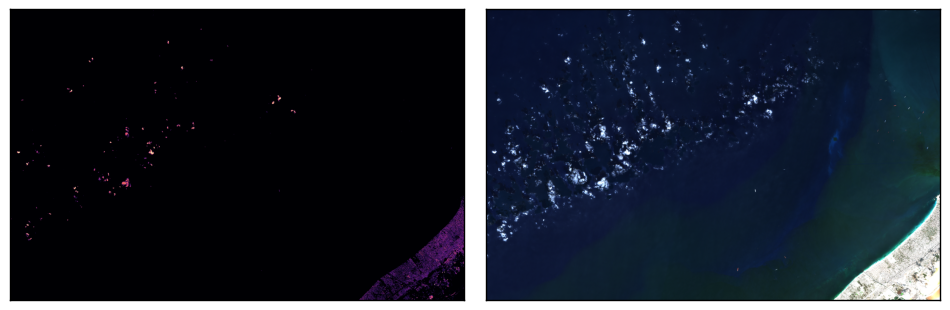

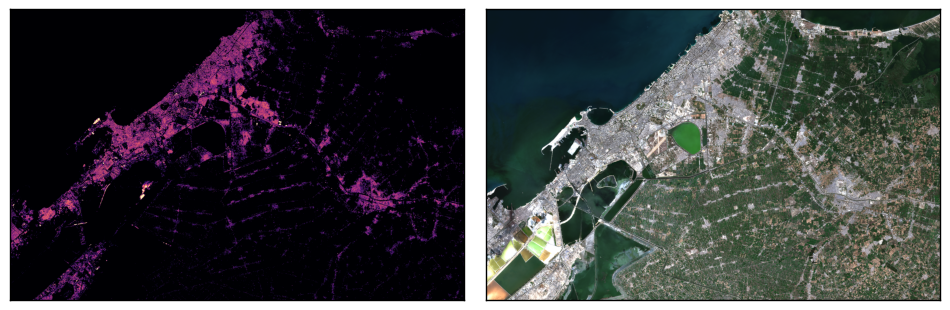

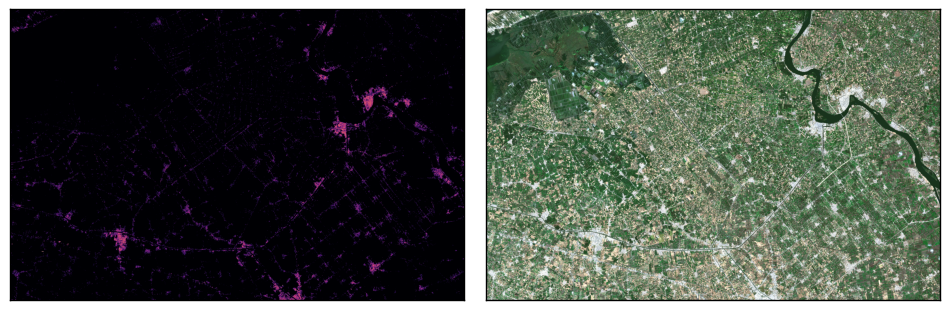

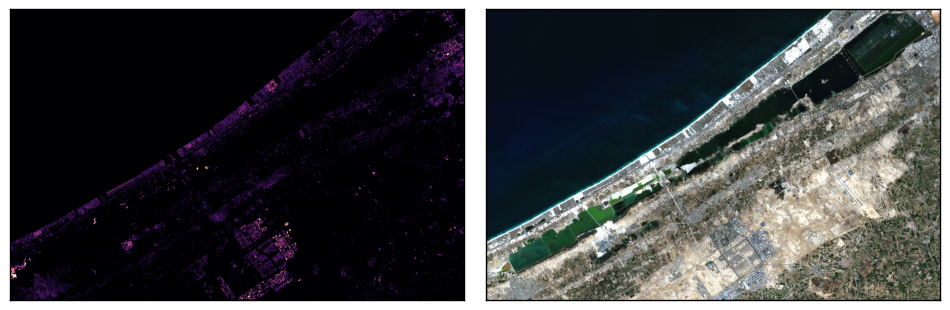

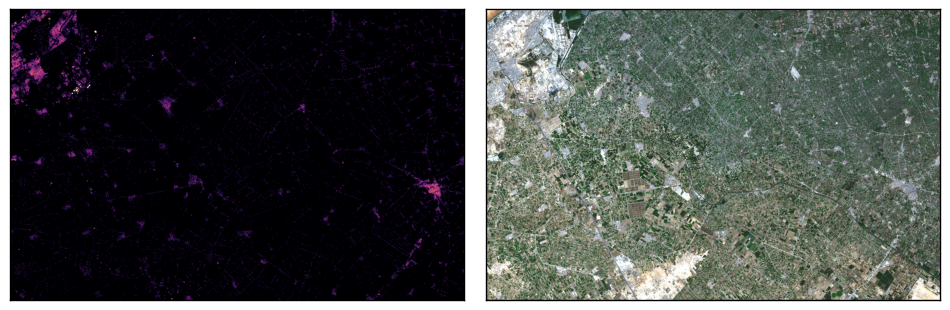

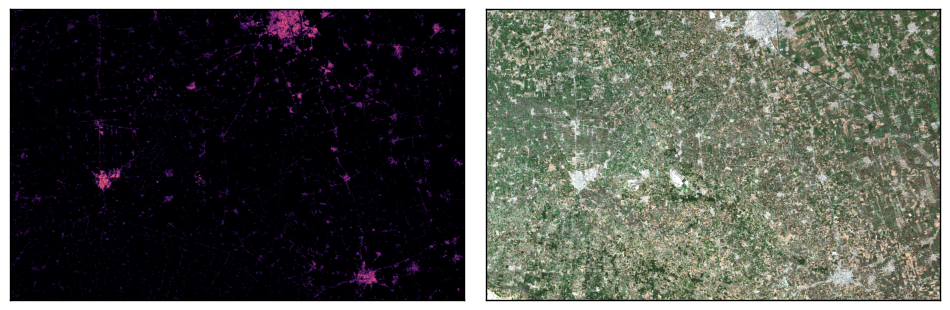

In [16]:
s2_path = '../data/S2.tif'

chunks = 9
id = 0
predicted_files = []

for arr, offset in beo.raster_to_array_chunks(s2_path, chunks, filled=True, fill_value=0.0, cast=np.float32):
  # Normalise the S2 data
  arr, _statdict = beo.scaler_truncate(arr, 0.0, 10000.0)

  # When running inference on computer vision models, especially small models like this,
  # its very common to see noise around the edges of the patches.
  # To alleviate this, we can predict multiple overlapping patches and weigh edge pixels less.
  # We can also take a robust score of the predictions, such as 'MAD', 'Median', or 'Olympian',
  # to create nice smooth predictions, even for very small models.
  with torch.no_grad():
    predicted = beo.predict_array(
      arr,
      predict,
      tile_size=PATCH_SIZE,
      n_offsets=3,
      merge_method='median',
      edge_weighted=True
    )

  # Render an RGB image for comparison
  rgb = render_s2_as_rgb(arr[:, :, 0:3][:, :, ::-1])

  fig, (ax1, ax2) = custom_subplots(nrows=1, ncols=2, size=(12, 8))
  ax1.imshow(predicted, vmin=0.0, vmax=100.0, cmap='magma')
  ax2.imshow(rgb)

  plt.show()

  # Save the predicted file
  RESULT_FOLDER = os.path.abspath(os.path.join(os.getcwd(), '..', 'results'))
  predicted_file = beo.array_to_raster(
    predicted,
    reference=s2_path,
    out_path=os.path.join(RESULT_FOLDER, f'predicted_{id}.tif'),
    pixel_offsets=offset
  )

  id += 1
  predicted_files.append(predicted_file)